<a href="https://colab.research.google.com/github/bhavinithak/DeepLearning_Pytorch/blob/main/Titanic_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
creds='{"username":"bbbttt","key":"a074f22360ca98d6882ecf9a447e71d3"}'
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

path=Path('titanic')

if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

!ls {path}

gender_submission.csv  test.csv  train.csv


In [3]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

#Data Prep

In [4]:
df=pd.read_csv(path/'train.csv')
tst_df=pd.read_csv(path/'test.csv')
modes=df.mode().iloc[0]

In [5]:
def proc_data(df):
  df['Fare']=df['Fare'].fillna(0)
  df.fillna(modes,inplace=True)
  df['LogFare']=np.log1p(df['Fare'])
  df['Embarked']=pd.Categorical(df['Embarked'])
  df['Sex']=pd.Categorical(df['Sex'])

In [6]:
proc_data(df)
proc_data(tst_df)

In [7]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [8]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [9]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

#Training

In [10]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,tst_df=train_test_split(df,test_size=0.25)
trn_df[cats]=trn_df[cats].apply(lambda x: x.cat.codes)
tst_df[cats]=tst_df[cats].apply(lambda x: x.cat.codes)

In [11]:
def xs_y(df):
  xs=df[cats+conts]
  y=df[dep] if dep in df else None
  return xs, y

In [12]:
trn_xs,trn_y=xs_y(trn_df)
tst_xs,tst_y=xs_y(tst_df)

In [13]:
tst_xs.head()

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass
709,1,0,24.0,1,1,2.787834,3
439,1,2,31.0,0,0,2.442347,2
840,1,2,20.0,0,0,2.188856,3
720,0,2,6.0,0,1,3.526361,2
39,0,0,14.0,1,0,2.504848,3


In [14]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz

m=DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs,trn_y)

In [15]:
import graphviz

def draw_tree(t,df,size=10,ratio=0.6,precision=2,**kwargs):
  s=export_graphviz(t,out_file=None,feature_names=df.columns,filled=True,rounded=True,special_characters=True,precision=precision,rotate=False,**kwargs)
  return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}',s))

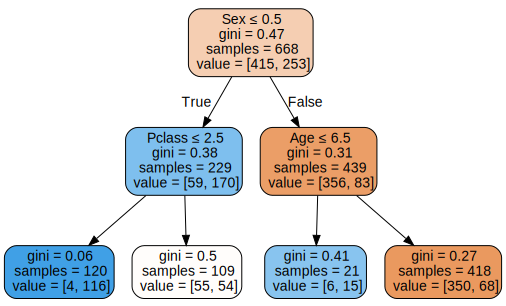

In [16]:
draw_tree(m,trn_xs)

In [17]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [18]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [19]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(tst_y,m.predict(tst_xs))

0.2242152466367713

In [20]:
# Bigger tree

m1=DecisionTreeClassifier(min_samples_leaf=50)
m1.fit(trn_xs,trn_y)
preds=m1.predict(tst_xs)
mean_absolute_error(tst_y,preds)

0.18385650224215247

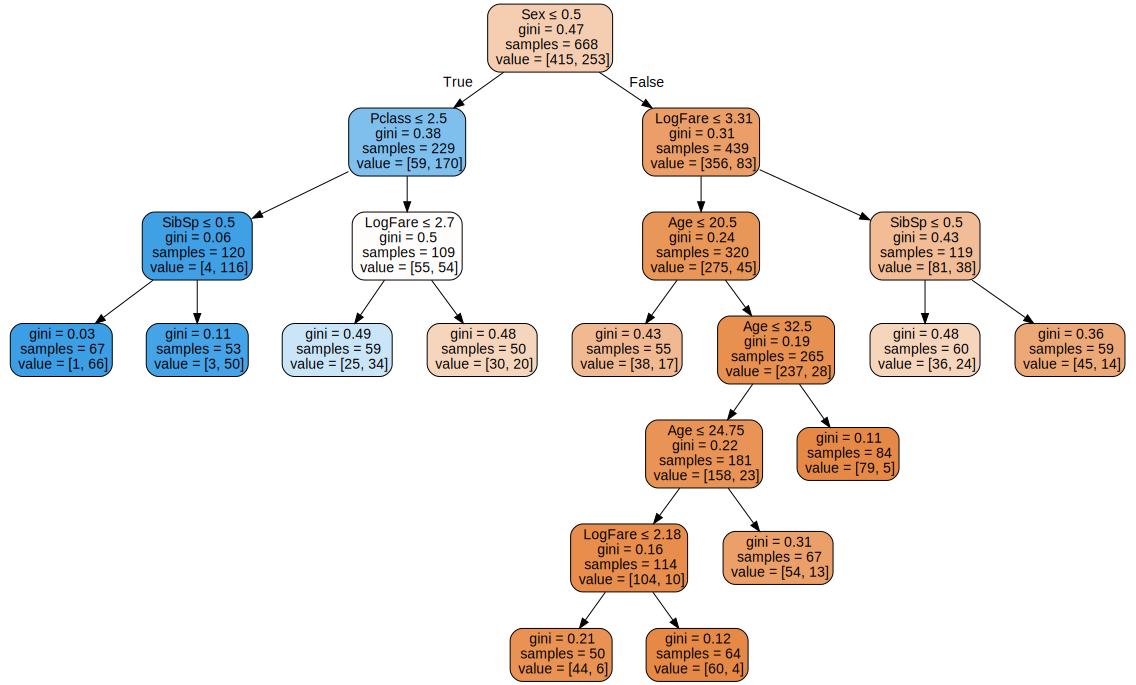

In [21]:
draw_tree(m1,trn_xs,size=52)

In [22]:
mean_absolute_error(tst_y,m1.predict(tst_xs))

0.18385650224215247

In [23]:
#tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m1.predict(tst_xs), 'tree')

#Random Forest

In [24]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [25]:
trees = [get_tree() for t in range(100)]

In [26]:
all_probs = [t.predict(tst_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0) ##mean is the general method

mean_absolute_error(tst_y, avg_probs)

0.2272645739910314

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(100,min_samples_leaf=5,oob_score=True)
rf.fit(trn_xs,trn_y)

mean_absolute_error(tst_y,rf.predict(tst_xs))

0.18834080717488788

In [36]:
subm(rf.predict(tst_xs), 'rf')

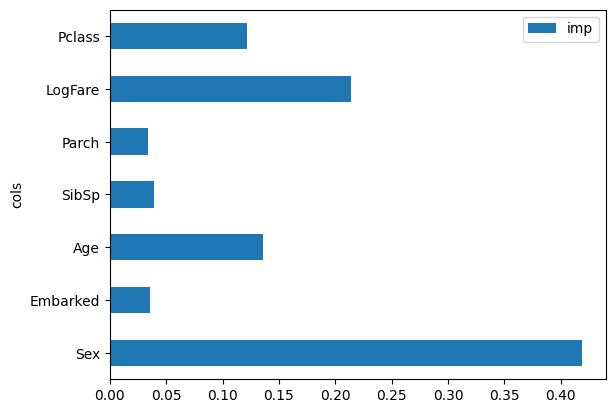

In [32]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

#Prediction confidence

In [42]:
#instead of mean we can use standard deviation to get prediction confidencde
preds=np.stack([t.predict(tst_xs) for t in trees])

In [43]:
preds.shape

(100, 223)

In [44]:
preds_std=preds.std(0)

In [45]:
preds_std[:5] ## if the std is high, confidence is low as all the trees are giving different values

array([0.3756328 , 0.3       , 0.38418745, 0.09949874, 0.49638695])

#partial dependence

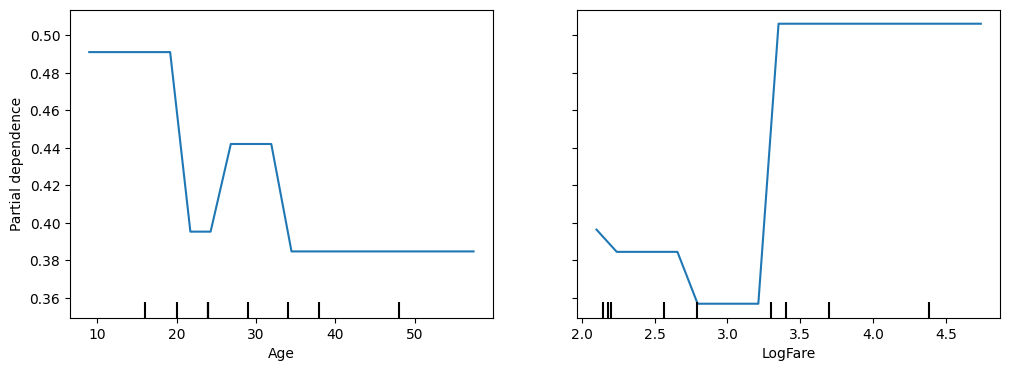

In [47]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m1, tst_xs, ['Age','LogFare'],
                        grid_resolution=20, ax=ax);

#Tree interpreter (Factors that influence prediciton)

In [50]:
!pip install treeinterpreter
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3388 sha256=5a73ded9078f8b87da4bcb8b4e21d399e081d9452e1c1394743b83373663d394
  Stored in directory: /root/.cache/pip/wheels/bd/34/6c/58fce34a3b8ec5607aff650db14ceb41db8223ac217423371b
Successfully built waterfallcharts


In [51]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [53]:
row = tst_xs.iloc[:5]

In [58]:
row

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass
709,1,0,24.0,1,1,2.787834,3
439,1,2,31.0,0,0,2.442347,2
840,1,2,20.0,0,0,2.188856,3
720,0,2,6.0,0,1,3.526361,2
39,0,0,14.0,1,0,2.504848,3


In [54]:
prediction,bias,contributions = treeinterpreter.predict(m1, row.values)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [55]:
prediction[0], bias[0], contributions[0].sum()


(array([0.9375, 0.0625]),
 array([0.62125749, 0.37874251]),
 -5.551115123125783e-17)

In [71]:
contributions[0][:,0]

array([0.18967646, 0.        , 0.0529057 , 0.        , 0.        , 0.07366036, 0.        ])

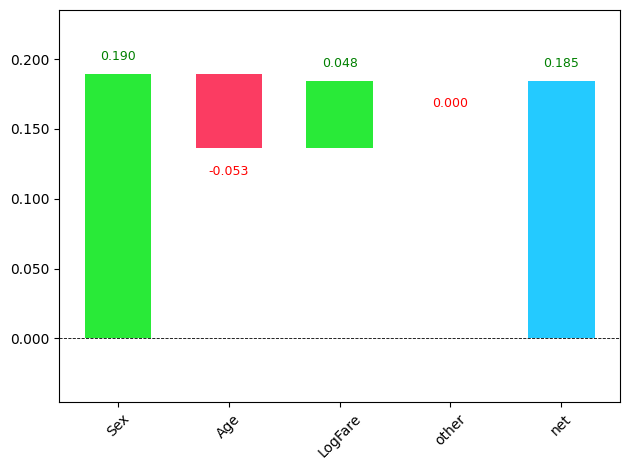

In [76]:
waterfall(tst_xs.columns, contributions[1][:,0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');